In [1]:
# python imports
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 
import numpy as np 
import os

# PyCS3 imports
import pycs3.gen.lc
import pycs3.gen.lc_func 
import pycs3.gen.mrg
import pycs3.gen.util
import pycs3.gen.splml 
import logging
loggerformat='%(message)s' # show messages
logging.basicConfig(format=loggerformat,level=logging.INFO)
import pycs3.regdiff.multiopt # regdiff
import pycs3.regdiff.rslc 
import pycs3.spl.topopt #spline
import pycs3.sim.draw # sim
import pycs3.sim.run
import pycs3.sim.plot
import pycs3.sim.twk
#import pycs3.tdcomb.plot # uncertainties
#import pycs3.tdcomb.comb

import warnings # ignore warnings (there are too many its annoying)
warnings.filterwarnings("ignore")

In [2]:
# test data from: https://arxiv.org/pdf/1706.09424.pdf
# found on cosmograil -- released data
filepath='/Users/gilliancartwright/Desktop/summerproject/Exploring_PyCS3/'
filename = filepath+'HE0435_Bonvin2016.rdb'


In [3]:
# function to grab curve info from rbd and plot light curves (needed for real data, not simulation)
def get_curves(filename):
    # get light curves from rbd file
    lcs = [
    pycs3.gen.lc_func.rdbimport(filename, 'A', 'mag_A', 'magerr_A', "Trial"),
    pycs3.gen.lc_func.rdbimport(filename, 'B', 'mag_B', 'magerr_B', "Trial"),
    pycs3.gen.lc_func.rdbimport(filename, 'C', 'mag_C', 'magerr_C', "Trial"),
    pycs3.gen.lc_func.rdbimport(filename, 'D', 'mag_D', 'magerr_D', "Trial")
    ]
    
    # display initial light curves
    pycs3.gen.mrg.colourise(lcs) # Gives each curve a different colour.
    pycs3.gen.lc_func.display(lcs, figsize= (15,10), title='Observed Light Curves') # show plot
    return lcs

In [4]:
# Define spline and regdiff functions

def spl(lcs, kn):
        spline = pycs3.spl.topopt.opt_rough(lcs, nit=5, knotstep=kn+10, verbose=False) # large grain steps
        spline = pycs3.spl.topopt.opt_fine(lcs, nit=10, knotstep=kn, verbose=False) # fine grain steps
        return spline
    
# define special regdiff function (used for optimization in stats)
def regdiff(lcs, **kwargs):
    return pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs['pd'], covkernel=kwargs['covkernel'], 
                                         pow=kwargs['pow'], errscale=kwargs['errscale'], 
                                         verbose=False, method="weights")

In [5]:
def shift_curves(lcs, initial_guess):
    pycs3.gen.lc_func.applyshifts(lcs, initial_guess, [0.,0.,0.,0.]) # initial guess of the time delay
    
    # Spline
    kn=20 #knotstep
    mlknotstep = 200 # microlensing knot step (must be much larger than kn)

    # account for microlensing:
    for lc in lcs : 
        pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) 

    # run spline function now that microlensing is accounted for
    spline = spl(lcs, kn)
    pycs3.gen.lc_func.display(lcs, [spline], figsize = (15,10), showdelays =True) # plot with spline function
    
    # write pickle of spline
    pycs3.gen.util.writepickle([lcs,spline], filepath+"/optcurves.pkl")
    
    # calculate time delays
    spline_time_delays = pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True)
    print("===================================")
    print ("Spline calculated time delays:")
    print (spline_time_delays) 
    
    # Regression Difference
    kwargs_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'errscale': 1., 'amp':1., 'scale':200., 
                 'verbose': True, 'method': "weights"}
    
    # show regdiff plots
    myrslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'],
                                         pow=kwargs_reg['pow'], amp=kwargs_reg['amp'], scale=kwargs_reg['scale'],
                                          errscale=kwargs_reg['errscale']) for l in lcs] # why are we redoing this?
    rslcs_residuals = [pycs3.regdiff.rslc.subtract(myrslcs[0],myrslcs[i]) for i in [1,2,3]] # residuals plot?

    fig1 = plt.figure(figsize=(15, 10))
    gs1 = gridspec.GridSpec(11, 2)
    gs1.update(left=0.08, right=0.96, top=0.98, bottom=0.05, wspace=0.05, hspace=0.09)
    ax1 = plt.subplot(gs1[:8, :])
    ax2 = plt.subplot(gs1[8:9, :],sharex=ax1)
    ax3 = plt.subplot(gs1[9:10, :],sharex=ax1)
    ax4 = plt.subplot(gs1[10:11, :],sharex=ax1)

    #colorize the residuals curves : 
    for j,lc in enumerate(rslcs_residuals):
        lc.plotcolour = lcs[j+1].plotcolour

    #prepare the legend for the difference curves
    disptext = []
    for j,lc in enumerate(rslcs_residuals) :
        ycoord = 0.5
        xcoord = 0.03
        kwargs = {"fontsize": 14, "color": lcs[j+1].plotcolour}
        txt = "A - %s"%lcs[j+1].object
        disptext.append((xcoord, ycoord, txt, kwargs))

    #plot the curves, regression, and difference curves : 
    pycs3.gen.lc_func.display(lcs, myrslcs, showdelays=False, showlegend=False,
                        title=r"$\mathrm{Regression\ Difference }$", filename = "screen", ax=ax1,  style="cosmograil_dr1")
    pycs3.gen.lc_func.display([],[rslcs_residuals[0]], showdelays=False, showlegend=False, filename = "screen", ax=ax2, style="cosmograil_dr1", text = [disptext[0]])
    pycs3.gen.lc_func.display([],[rslcs_residuals[1]], showdelays=False, showlegend=False, filename = "screen", ax=ax3, style="cosmograil_dr1", text = [disptext[1]])
    pycs3.gen.lc_func.display([],[rslcs_residuals[2]], showdelays=False, showlegend=False, filename = "screen", ax=ax4, style="cosmograil_dr1", text = [disptext[2]])

    #adjust the axis
    ax1.get_xaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.set_ylabel('$m_{%s} - m_{%s}$ \n $\mathrm{(mag)}$'%(lcs[0].object[0], lcs[1].object[-1]), fontsize = 12)
    ax3.get_xaxis().set_visible(False)
    ax3.set_ylabel('$m_{%s} - m_{%s}$ \n $\mathrm{(mag)}$'%(lcs[0].object[0], lcs[2].object[-1]), fontsize = 12)
    ax4.set_ylabel("Regression Difference \n Residuals (mag)", fontsize = 9)
    ax4.set_ylabel('$m_{%s} - m_{%s}$ \n $\mathrm{(mag)}$'%(lcs[0].object[0], lcs[3].object[-1]), fontsize = 12)

    plt.show()
    plt.close()

    regdiff_time_delays = pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True)
    
    print("===================================")
    print ("Regression Difference time delays:")
    print (regdiff_time_delays)
    
    

In [6]:
# function to run basic stats on intrinstic variation of optimization. looking for sharp peaks. 
#If not sharp peaks, then model is not fitting well to data and need to fix initial guess

def basic_stats(pickle):    
    # make copies to test intrinstic variation
    lcs, spline = pycs3.gen.util.readpickle(pickle)
    pycs3.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=2, simset="copies", destpath=filepath)

    # optimize copies with spline and regdiff
    kwargs_optim_spl = {'kn':20}
    kwargs_optim_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1.}

    success_dic = pycs3.sim.run.multirun("copies", lcs, spl, kwargs_optim_spl, optset="spl", 
                                     tsrand=10.0, keepopt=True, destpath=filepath)
    success_dic = pycs3.sim.run.multirun("copies", lcs, regdiff, kwargs_optim_reg, optset="reg", 
                                     tsrand=10.0, keepopt=True, destpath=filepath) 
    
    ## collect and show results
    dataresults = [
        pycs3.sim.run.collect(directory =os.path.join(filepath,"sims_copies_opt_reg"), plotcolour= "red", name="Regression difference technique"),
        pycs3.sim.run.collect(directory = os.path.join(filepath,"sims_copies_opt_spl"),  plotcolour="blue", name="Free-knot spline technique")
    ]

    pycs3.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False, dataout=True, usemedian=True, outdir=filepath)


In [7]:
def sim_lcs(filename):
    """
    Simulates mock light curves based on real data from file
    Output:M simulated lcs
    
    """
    lcs=get_curves(filename) 
    

    ### Create copy of data
    # Run spline to get pickle with spline to make mocks of
    kn=20 #knotstep
    mlknotstep = 200 
    for lc in lcs : # microlensing
        pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) 
    # run spline
    spline = spl(lcs, kn)
    pycs3.gen.lc_func.display(lcs, [spline], figsize = (15,10), showdelays =True) # plot with spline function
    
    # write pickle of spline
    pycs3.gen.util.writepickle([lcs,spline], filepath+"optspl.pkl")
    
    # read pickle
    (lcs, spline) = pycs3.gen.util.readpickle(filepath+"optspl.pkl")

    
    ### Make Mock 
    # make mocklcs
    pycs3.sim.draw.saveresiduals(lcs, spline)
    mocklcs = pycs3.sim.draw.draw(lcs, spline, shotnoise="mcres") # with gaussian noise (sigma from residuals)

    # Manually remove shifts from all curves :
    for l in mocklcs:
            l.resetshifts() # also removes microlensing
            l.plotcolour = "black"
    for l in lcs:
            l.resetshifts()
          
    # Plot original with mock on top
    pycs3.gen.lc_func.display(lcs + mocklcs, showdelays=False, title='Original LCs with Simulated LCs Overlayed')
    
    # So these lightcurves match to the spline
    pycs3.sim.draw.saveresiduals(lcs, spline)
    
    # Choose a shift for mocklcs:
    manual_shift=[0., -100., -200., -500.]
    pycs3.gen.lc_func.applyshifts(mocklcs, manual_shift, [0.,0.,0.,0.]) # added shift for C and D

    # add rand gaussian noise to mock curves (sigma is previoulsy saved residuals)
    pycs3.gen.mrg.colourise(mocklcs) # Gives each curve a different colour.
    pycs3.gen.lc_func.display(mocklcs, [spline], title='Manually Shifted Simulated Light Curves')
    
    
    true_time=[]

    for l in mocklcs: # print true timeshift
        true_time.append(l.truetimeshift)
        
    AB=manual_shift[1]+true_time[1]-true_time[0]
    AC=manual_shift[2]+true_time[2]-true_time[0]
    AD=manual_shift[3]+true_time[3]-true_time[0]
    
    sim_time_delays=[AB,AC,AD]

    print("Simulated Time Delays: ")
    print(f"AB = {AB}")
    print(f"AC = {AC}")
    print(f"AD = {AD}")

    return mocklcs, sim_time_delays
    
    

Checking header of "HE0435_Bonvin2016.rdb"...
Reading "HE0435_Bonvin2016.rdb"...
[Trial/A] with 884 points imported (0 of them masked).
Checking header of "HE0435_Bonvin2016.rdb"...
Reading "HE0435_Bonvin2016.rdb"...
[Trial/B] with 884 points imported (0 of them masked).
Checking header of "HE0435_Bonvin2016.rdb"...
Reading "HE0435_Bonvin2016.rdb"...
[Trial/C] with 884 points imported (0 of them masked).
Checking header of "HE0435_Bonvin2016.rdb"...
Reading "HE0435_Bonvin2016.rdb"...
[Trial/D] with 884 points imported (0 of them masked).


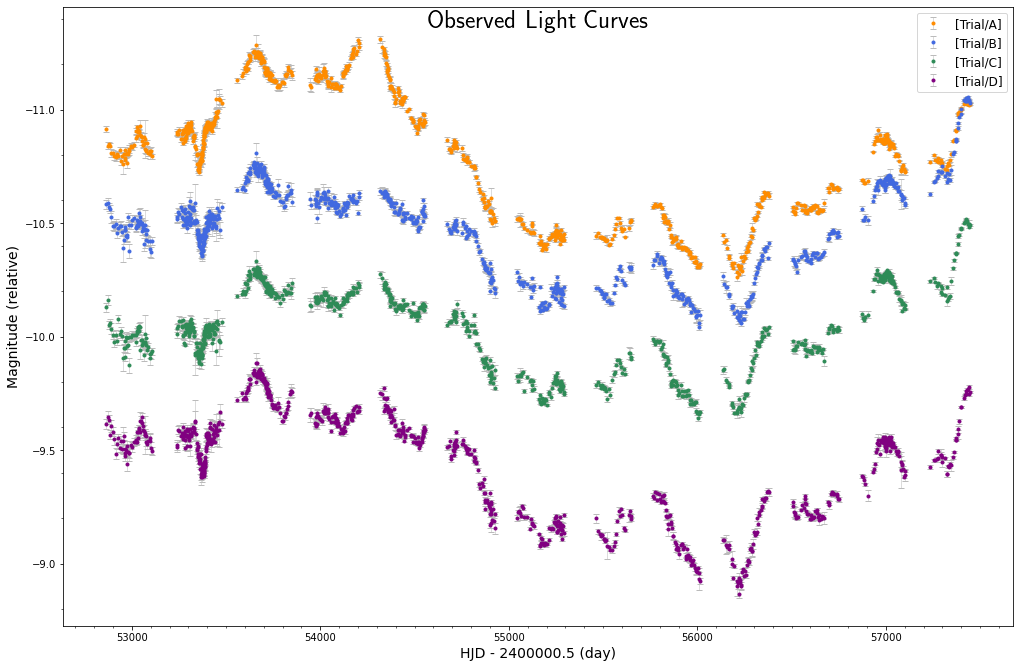

Starting ML optimization ...
Working on the spline ML of [Trial/A]|~3/u/21~|
Working on the spline ML of [Trial/B](0.000,-0.346,0)|~3/u/21~|
Working on the spline ML of [Trial/C](0.000,-0.813,0)|~3/u/21~|
Working on the spline ML of [Trial/D](0.000,-1.327,0)|~3/u/21~|
Done !


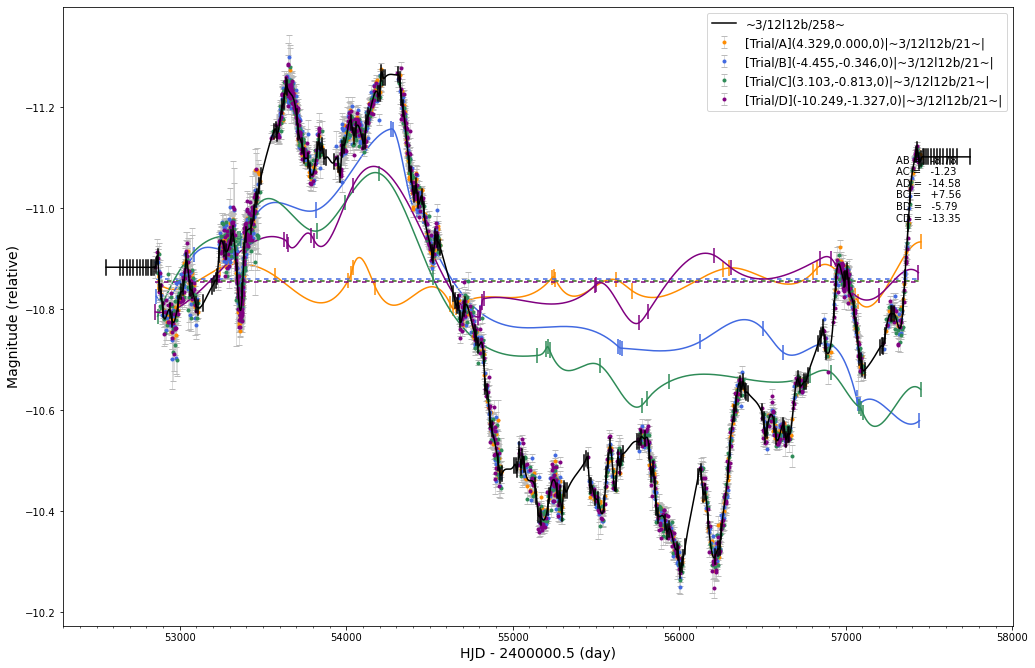

Wrote /Users/gilliancartwright/Desktop/summerproject/Exploring_PyCS3/optspl.pkl
Read /Users/gilliancartwright/Desktop/summerproject/Exploring_PyCS3/optspl.pkl


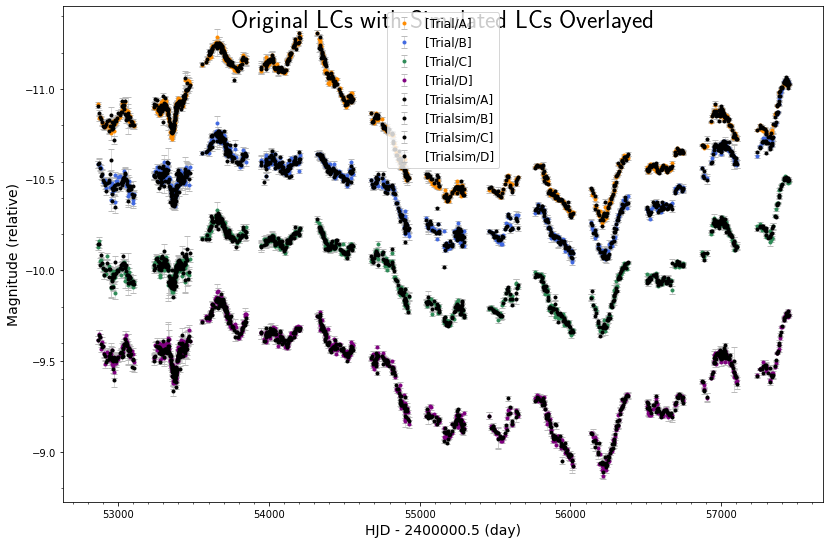

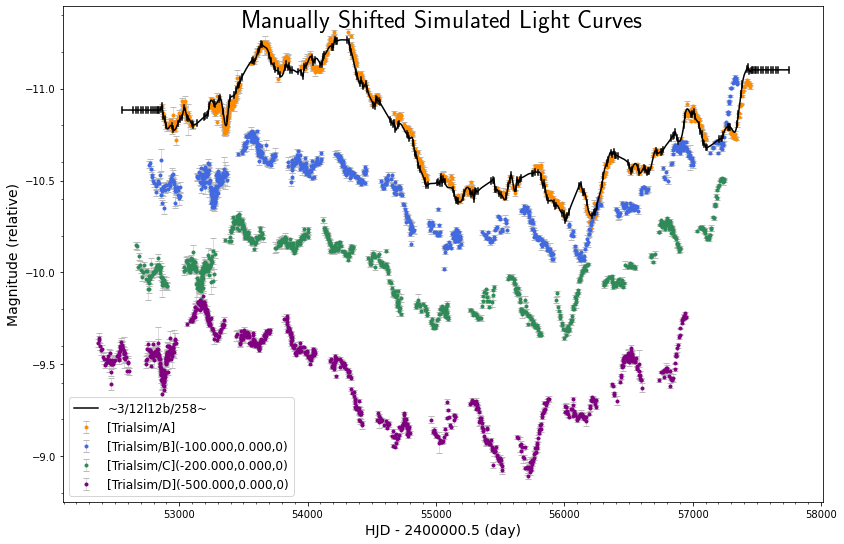

Simulated Time Delays: 
AB = -108.78385490649352
AC = -201.22663824793125
AD = -514.5785321027423


In [8]:
mocklcs,sim_time_delays=sim_lcs(filename)

Starting ML optimization ...
Working on the spline ML of [Trialsim/A]|~3/u/21~|
Working on the spline ML of [Trialsim/B](-100.000,-0.350,0)|~3/u/21~|
Working on the spline ML of [Trialsim/C](-200.000,-0.816,0)|~3/u/21~|
Working on the spline ML of [Trialsim/D](-500.000,-1.329,0)|~3/u/21~|
Done !


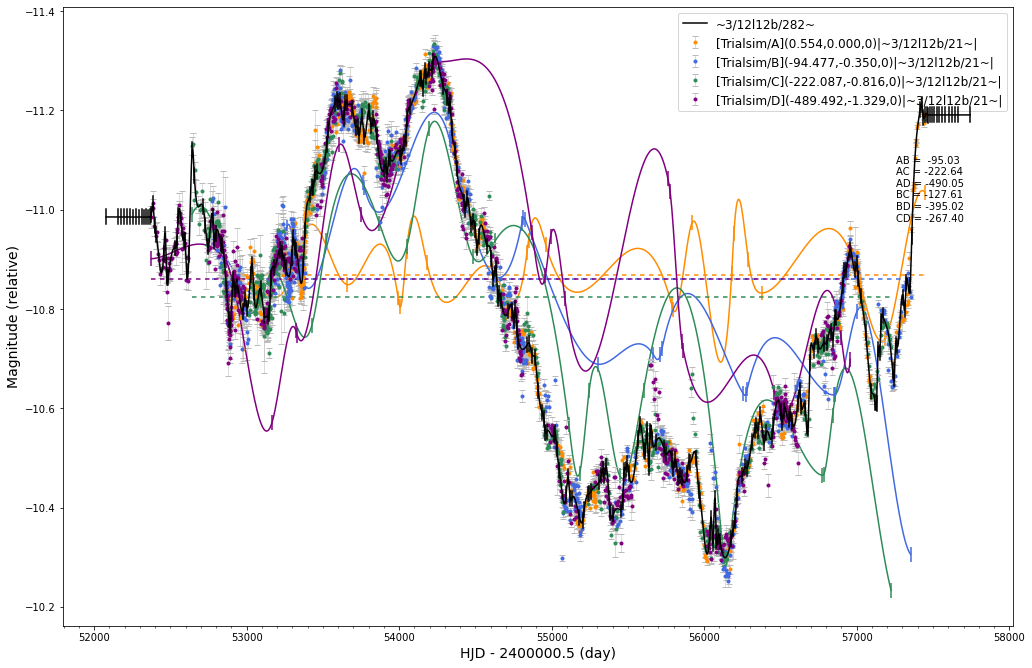

Wrote /Users/gilliancartwright/Desktop/summerproject/Exploring_PyCS3//optcurves.pkl


Spline calculated time delays:
AB =  -95.03
AC = -222.64
AD = -490.05
BC = -127.61
BD = -395.02
CD = -267.40


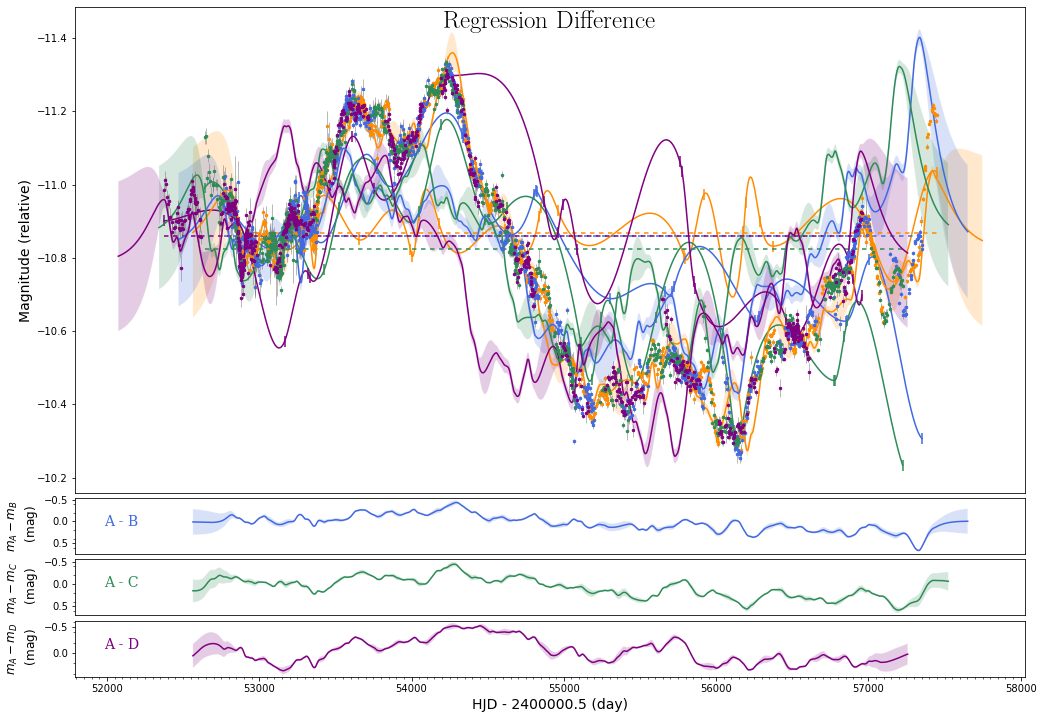

Regression Difference time delays:
AB =  -95.03
AC = -222.64
AD = -490.05
BC = -127.61
BD = -395.02
CD = -267.40
Actual Time Delays from Simulation:
AB = -108.78385490649352
AC = -201.22663824793125
AD = -514.5785321027423


In [9]:
# test if model can return simulation time delays 

shift_curves(mocklcs, initial_guess=[0.,-100.,-200.,-500.])

print("===================================")
print("Actual Time Delays from Simulation:")
print(f"AB = {sim_time_delays[0]}")
print(f"AC = {sim_time_delays[1]}")
print(f"AD = {sim_time_delays[2]}")

In [13]:
#pickle=filepath+"/optcurves.pkl"
#basic_stats(pickle)
